First I will load in the dataset

In [1]:
import pandas as pd

file = "steel.csv"
df = pd.read_csv(file)

df.head(), df.shape

(   normalising_temperature  tempering_temperature  percent_silicon  \
 0                  178.500                    275           0.1530   
 1                  178.500                    950           0.1530   
 2                  178.500                    375           0.1530   
 3                  178.500                    900           0.1530   
 4                  189.525                    900           0.1624   
 
    percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
 0          0.970575           0.942          0.8870              0.0   
 1          1.212726           0.942          0.8870              0.0   
 2          1.621165           0.942          0.8870              0.0   
 3          0.809989           0.942          0.8870              0.0   
 4          1.036229           0.849          0.9382              0.0   
 
    percent_carbon  percent_manganese  tensile_strength  
 0           1.920                0.0         25.107613  
 1           1.9

In [2]:
# select independent and dependent variables
dependent_col = "tensile_strength"
independent_cols = [col for col in df.columns if col != dependent_col]

X = df[independent_cols]
y = df[dependent_col]

X.head(), y.head(), X.shape, y.shape

(   normalising_temperature  tempering_temperature  percent_silicon  \
 0                  178.500                    275           0.1530   
 1                  178.500                    950           0.1530   
 2                  178.500                    375           0.1530   
 3                  178.500                    900           0.1530   
 4                  189.525                    900           0.1624   
 
    percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
 0          0.970575           0.942          0.8870              0.0   
 1          1.212726           0.942          0.8870              0.0   
 2          1.621165           0.942          0.8870              0.0   
 3          0.809989           0.942          0.8870              0.0   
 4          1.036229           0.849          0.9382              0.0   
 
    percent_carbon  percent_manganese  
 0           1.920                0.0  
 1           1.920                0.0  
 2          

I will preprocess my data using standard scaler as performance will be affected

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[-1.84808128, -1.8422778 ,  1.10582626, -1.18024956,  2.30540967,
        -1.1534779 , -1.07147549,  0.55514542, -0.92684122],
       [-1.84808128,  0.76403733,  1.10582626, -0.24905658,  2.30540967,
        -1.1534779 , -1.07147549,  0.55514542, -0.92684122],
       [-1.84808128, -1.45615704,  1.10582626,  1.32159528,  2.30540967,
        -1.1534779 , -1.07147549,  0.55514542, -0.92684122],
       [-1.84808128,  0.57097695,  1.10582626, -1.7977837 ,  2.30540967,
        -1.1534779 , -1.07147549,  0.55514542, -0.92684122],
       [-1.78009749,  0.57097695,  1.22247693, -0.9277751 ,  0.94827581,
        -0.46348087, -1.07147549,  1.17591397, -0.92684122]])

In [4]:
# set up evaluation metrics

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
# implementing 10 fold cross validation
from sklearn.model_selection import KFold

def evaluate_model(model,X,Y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    train_rmse_list = []
    train_r2_list = []
    test_rmse_list = []
    test_r2_list = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        # Training set predictions
        y_train_pred = model.predict(X_train)
        train_rmse_list.append(rmse(y_train, y_train_pred))
        train_r2_list.append(r2_score(y_train, y_train_pred))
        
        # Test set predictions
        y_test_pred = model.predict(X_test)
        test_rmse_list.append(rmse(y_test, y_test_pred))
        test_r2_list.append(r2_score(y_test, y_test_pred))
    
    avg_train_rmse = np.mean(train_rmse_list)
    avg_train_r2 = np.mean(train_r2_list)
    avg_test_rmse = np.mean(test_rmse_list)
    avg_test_r2 = np.mean(test_r2_list)
    
    return avg_train_rmse, avg_train_r2, avg_test_rmse, avg_test_r2

Now I will setup the SVR model with the default hyperparameters

In [6]:
from sklearn.svm import SVR

svr_default = SVR() #  C=1.0, epsilon=0.1, kernel='rbf', gamma ='scale'

train_rmse, train_r2, test_rmse, test_r2 = evaluate_model(svr_default, X_scaled, y)

print(f"SVR Default - Train RMSE: {train_rmse:.4f}, Train R²: {train_r2:.4f}")
print(f"SVR Default - Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")

SVR Default - Train RMSE: 79.1686, Train R²: 0.2437
SVR Default - Test RMSE: 78.6242, Test R²: 0.2345


Now I will explore using different values of C and plotting the results

In [7]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_rmse_results = []
train_r2_results = []
test_rmse_results = []
test_r2_results = []

for C in C_values:
    svr_model = SVR(C=C)
    train_rmse, train_r2, test_rmse, test_r2 = evaluate_model(svr_model, X_scaled, y)
    train_rmse_results.append(train_rmse)
    train_r2_results.append(train_r2)
    test_rmse_results.append(test_rmse)
    test_r2_results.append(test_r2)
    print(f"SVR with C={C}")
    print(f"  Train - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    print(f"  Test  - RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

SVR with C=0.001
  Train - RMSE: 91.5150, R²: -0.0106
  Test  - RMSE: 90.4941, R²: -0.0184
SVR with C=0.01
  Train - RMSE: 91.3848, R²: -0.0077
  Test  - RMSE: 90.3659, R²: -0.0155
SVR with C=0.01
  Train - RMSE: 91.3848, R²: -0.0077
  Test  - RMSE: 90.3659, R²: -0.0155
SVR with C=0.1
  Train - RMSE: 90.0912, R²: 0.0206
  Test  - RMSE: 89.0920, R²: 0.0134
SVR with C=0.1
  Train - RMSE: 90.0912, R²: 0.0206
  Test  - RMSE: 89.0920, R²: 0.0134
SVR with C=1
  Train - RMSE: 79.1686, R²: 0.2437
  Test  - RMSE: 78.6242, R²: 0.2345
SVR with C=1
  Train - RMSE: 79.1686, R²: 0.2437
  Test  - RMSE: 78.6242, R²: 0.2345
SVR with C=10
  Train - RMSE: 45.2542, R²: 0.7527
  Test  - RMSE: 47.3060, R²: 0.7209
SVR with C=10
  Train - RMSE: 45.2542, R²: 0.7527
  Test  - RMSE: 47.3060, R²: 0.7209
SVR with C=100
  Train - RMSE: 25.2167, R²: 0.9232
  Test  - RMSE: 33.9351, R²: 0.8524
SVR with C=100
  Train - RMSE: 25.2167, R²: 0.9232
  Test  - RMSE: 33.9351, R²: 0.8524
SVR with C=1000
  Train - RMSE: 15.6160

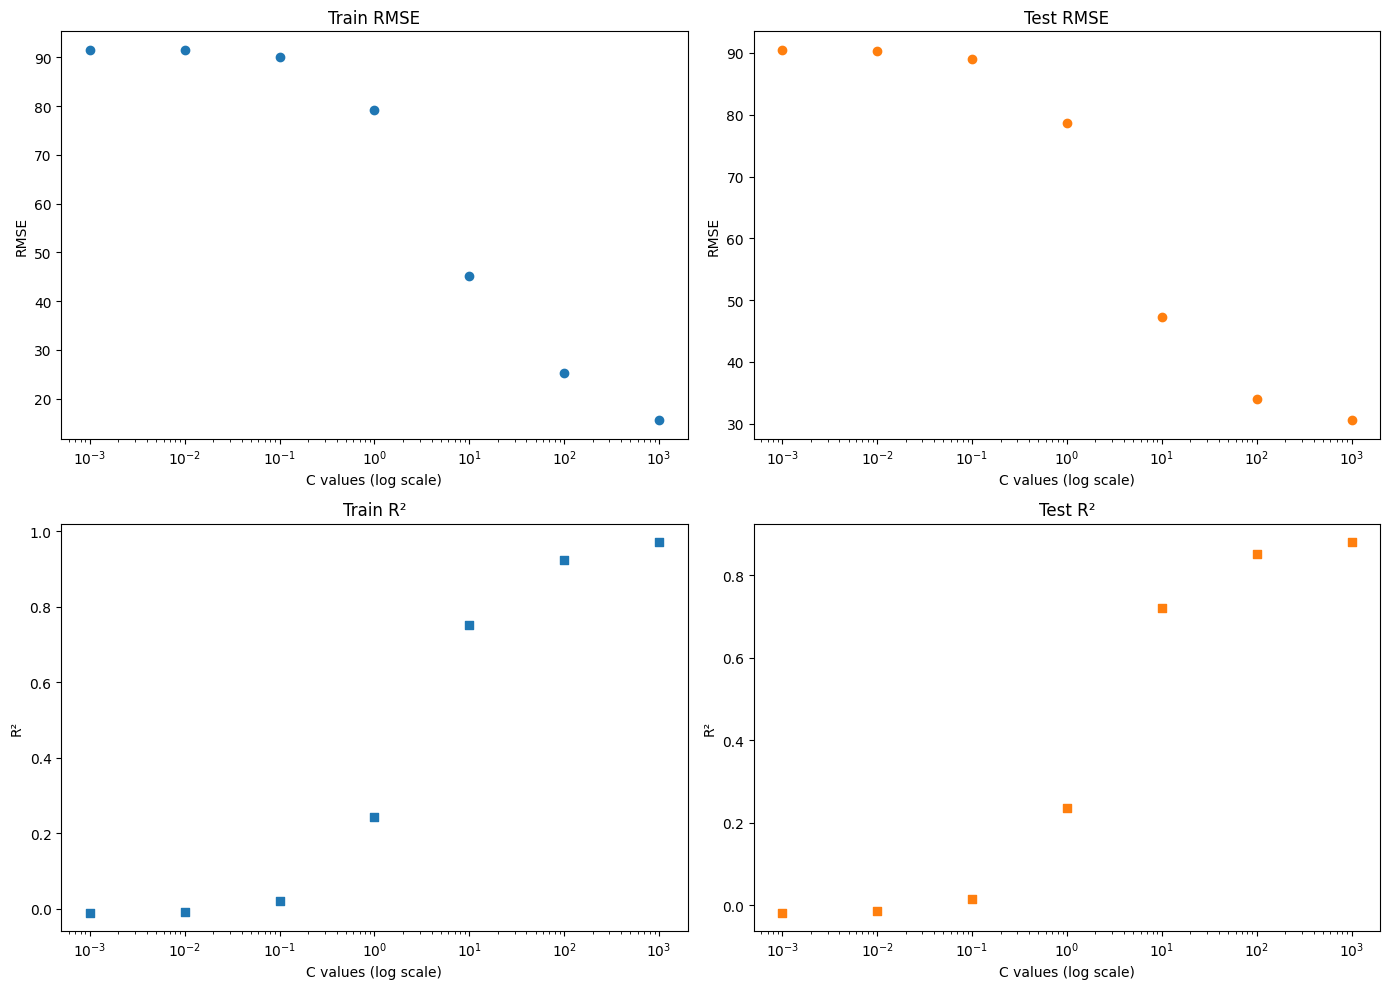

In [8]:
# plot results
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Train RMSE
ax1.scatter(C_values, train_rmse_results, marker='o', color='tab:blue')
ax1.set_xlabel('C values (log scale)')
ax1.set_ylabel('RMSE')
ax1.set_xscale('log')
ax1.set_title('Train RMSE')

# Test RMSE
ax2.scatter(C_values, test_rmse_results, marker='o', color='tab:orange')
ax2.set_xlabel('C values (log scale)')
ax2.set_ylabel('RMSE')
ax2.set_xscale('log')
ax2.set_title('Test RMSE')

# Train R²
ax3.scatter(C_values, train_r2_results, marker='s', color='tab:blue')
ax3.set_xlabel('C values (log scale)')
ax3.set_ylabel('R²')
ax3.set_xscale('log')
ax3.set_title('Train R²')

# Test R²
ax4.scatter(C_values, test_r2_results, marker='s', color='tab:orange')
ax4.set_xlabel('C values (log scale)')
ax4.set_ylabel('R²')
ax4.set_xscale('log')
ax4.set_title('Test R²')

plt.tight_layout()
plt.show()

Now I will explore tuning the gamma parameter and plotting results

In [9]:
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_rmse_results_gamma = []
train_r2_results_gamma = []
test_rmse_results_gamma = []
test_r2_results_gamma = []

for gamma in gamma_values:
    svr_model = SVR(gamma=gamma)
    train_rmse, train_r2, test_rmse, test_r2 = evaluate_model(svr_model, X_scaled, y)
    train_rmse_results_gamma.append(train_rmse)
    train_r2_results_gamma.append(train_r2)
    test_rmse_results_gamma.append(test_rmse)
    test_r2_results_gamma.append(test_r2)
    print(f"SVR with gamma={gamma}")
    print(f"  Train - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    print(f"  Test  - RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

SVR with gamma=0.001
  Train - RMSE: 90.8163, R²: 0.0048
  Test  - RMSE: 89.8166, R²: -0.0032
SVR with gamma=0.01
  Train - RMSE: 85.8165, R²: 0.1113
  Test  - RMSE: 84.9490, R²: 0.1030
SVR with gamma=0.1
  Train - RMSE: 78.7758, R²: 0.2511
  Test  - RMSE: 78.2156, R²: 0.2422
SVR with gamma=0.1
  Train - RMSE: 78.7758, R²: 0.2511
  Test  - RMSE: 78.2156, R²: 0.2422
SVR with gamma=1
  Train - RMSE: 89.3840, R²: 0.0359
  Test  - RMSE: 89.1025, R²: 0.0133
SVR with gamma=1
  Train - RMSE: 89.3840, R²: 0.0359
  Test  - RMSE: 89.1025, R²: 0.0133
SVR with gamma=10
  Train - RMSE: 90.6059, R²: 0.0094
  Test  - RMSE: 90.3591, R²: -0.0154
SVR with gamma=10
  Train - RMSE: 90.6059, R²: 0.0094
  Test  - RMSE: 90.3591, R²: -0.0154
SVR with gamma=100
  Train - RMSE: 90.7278, R²: 0.0067
  Test  - RMSE: 90.4886, R²: -0.0183
SVR with gamma=100
  Train - RMSE: 90.7278, R²: 0.0067
  Test  - RMSE: 90.4886, R²: -0.0183
SVR with gamma=1000
  Train - RMSE: 90.7428, R²: 0.0064
  Test  - RMSE: 90.5060, R²: -0.

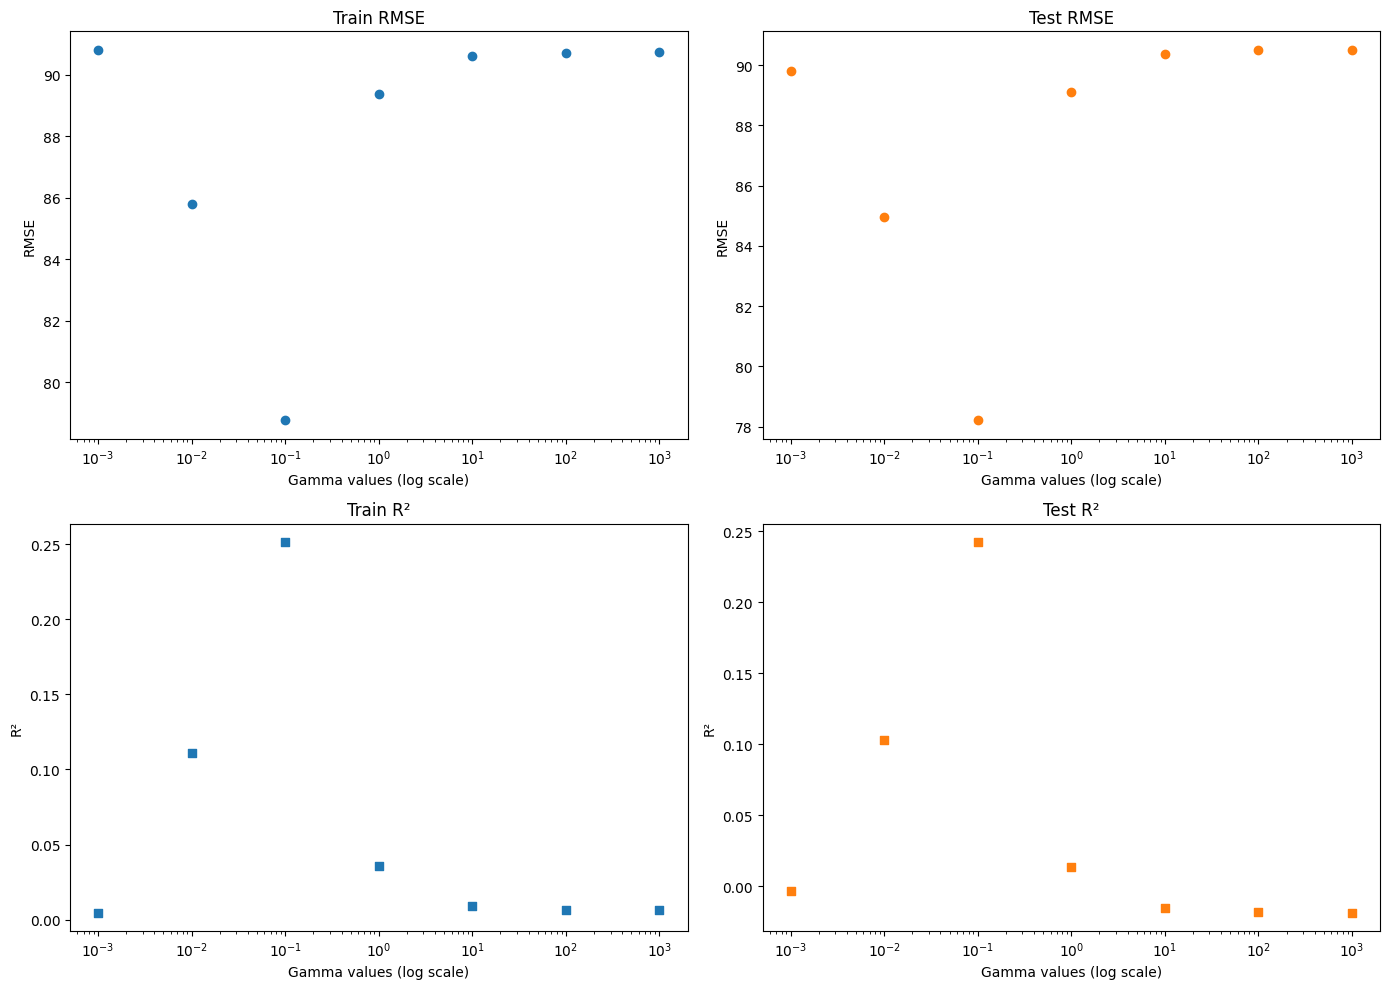

In [10]:
#plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Train RMSE
ax1.scatter(gamma_values, train_rmse_results_gamma, marker='o', color='tab:blue')
ax1.set_xlabel('Gamma values (log scale)')
ax1.set_ylabel('RMSE')
ax1.set_xscale('log')
ax1.set_title('Train RMSE')

# Test RMSE
ax2.scatter(gamma_values, test_rmse_results_gamma, marker='o', color='tab:orange')
ax2.set_xlabel('Gamma values (log scale)')
ax2.set_ylabel('RMSE')
ax2.set_xscale('log')
ax2.set_title('Test RMSE')

# Train R²
ax3.scatter(gamma_values, train_r2_results_gamma, marker='s', color='tab:blue')
ax3.set_xlabel('Gamma values (log scale)')
ax3.set_ylabel('R²')
ax3.set_xscale('log')
ax3.set_title('Train R²')

# Test R²
ax4.scatter(gamma_values, test_r2_results_gamma, marker='s', color='tab:orange')
ax4.set_xlabel('Gamma values (log scale)')
ax4.set_ylabel('R²')
ax4.set_xscale('log')
ax4.set_title('Test R²')

plt.tight_layout()
plt.show()

Now I will tune both hyperparameters together and see which pairing is the strongest

In [17]:
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Use same KFold strategy as evaluate_model for consistency
kf_consistent = KFold(n_splits=10, shuffle=True, random_state=42)

grid_svr = GridSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=kf_consistent)
grid_svr.fit(X_scaled, y)

best_params = grid_svr.best_params_
best_rmse = np.sqrt(-grid_svr.best_score_)

# Get R² for best model using cross_val_score with same cv
best_model = grid_svr.best_estimator_
best_r2_scores = cross_val_score(best_model, X_scaled, y, cv=kf_consistent, scoring='r2')
best_r2 = best_r2_scores.mean()

print(f"Best parameters: {best_params}")
print(f"Test RMSE (from GridSearchCV): {best_rmse:.4f}")
print(f"Test R² (from cross_val_score): {best_r2:.4f}")

Best parameters: {'C': 1000, 'gamma': 0.1}
Test RMSE (from GridSearchCV): 30.6660
Test R² (from cross_val_score): 0.8807


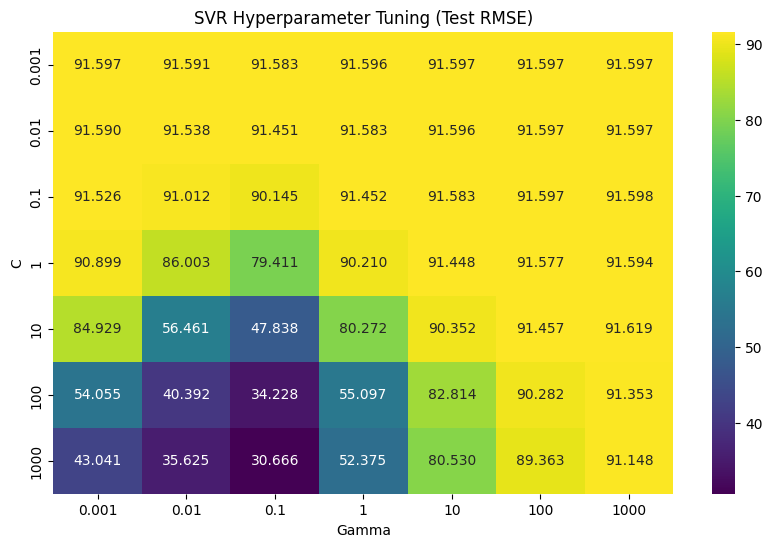

In [18]:
# create heatmap of results for test RMSE from GridSearchCV
import seaborn as sns

# Extract RMSE scores directly from GridSearchCV results
results = grid_svr.cv_results_
mean_test_scores = results['mean_test_score']
rmse_scores = np.sqrt(-mean_test_scores)
rmse_matrix = rmse_scores.reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(10, 6))
sns.heatmap(rmse_matrix, annot=True, fmt=".3f", xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap="viridis")
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('SVR Hyperparameter Tuning (Test RMSE)')
plt.show()

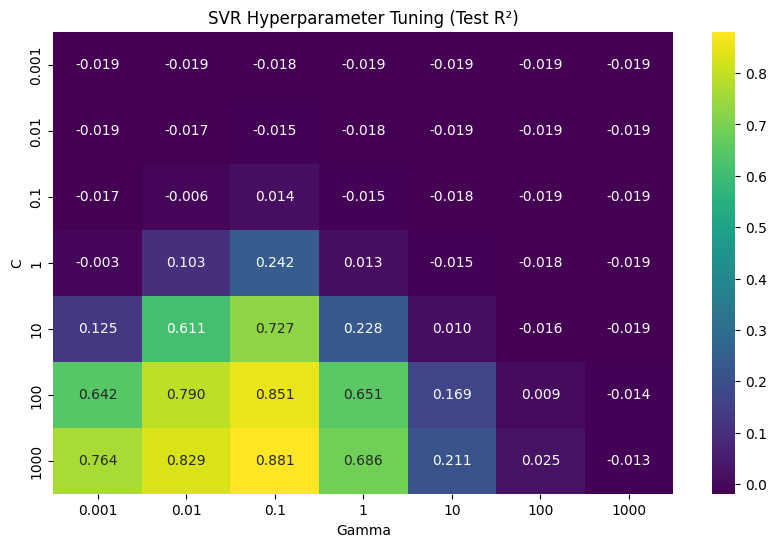

In [ ]:
# R^2 heatmap, compute from same data splits as GridSearchCV

r2_matrix = np.zeros((len(param_grid['C']), len(param_grid['gamma'])))

for i, C in enumerate(param_grid['C']):
    for j, gamma in enumerate(param_grid['gamma']):
        model = SVR(C=C, gamma=gamma)
        # Use same cv strategy as GridSearchCV
        r2_scores = cross_val_score(model, X_scaled, y, cv=kf_consistent, scoring='r2')
        r2_matrix[i, j] = r2_scores.mean()

plt.figure(figsize=(10, 6))
sns.heatmap(r2_matrix, annot=True, fmt='.3f', xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap='viridis')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('SVR Hyperparameter Tuning (Test R²)')
plt.show()